In [42]:
%matplotlib notebook

import csv, glob, os, platform, pprint, sys, urllib
import fastai as fai
import fastai.tabular as fat
import GPy
import GPyOpt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_toolkits as mpt
import numpy as np
import pandas as pd
# import pandas_ml as pdm
import scipy
import scipy.stats as scistat
import seaborn as sn
import sklearn as sk
import sklearn.decomposition as skd
import sklearn.discriminant_analysis as skda
import sklearn.ensemble as ske
# import sklearn.externals.joblib as skjob
import sklearn.feature_selection as skf
import sklearn.gaussian_process as skg
import sklearn.gaussian_process.kernels as skgk
import sklearn.linear_model as sklm
import sklearn.metrics as skme
import sklearn.model_selection as skm
import sklearn.naive_bayes as sknb
import sklearn.neighbors as skn
import sklearn.neural_network as sknn
import sklearn.pipeline as skpl
import sklearn.preprocessing as skp
import sklearn.svm as sksvm
import sklearn.tree as skt
import sklearn.utils as sku

RANDOM_STATE: int = 14
seed: int = 7

# set up pretty printer for easier data evaluation
p = pprint.PrettyPrinter(indent=4, width=30)
pretty = p.pprint

print(f"""
python: {platform.python_version()}\n
libraries loaded:
\tfastai: {fai.__version__}
\tmatplotlib: {mpl.__version__}
\tnumpy: {np.__version__}
\tpandas: {pd.__version__}
\tseaborn: {sn.__version__}
\tscipy: {scipy.__version__}
\tsklearn: {sk.__version__}
""")


python: 3.7.10

libraries loaded:
	fastai: 1.0.61
	matplotlib: 3.3.4
	numpy: 1.20.2
	pandas: 1.2.4
	seaborn: 0.11.1
	scipy: 1.6.2
	sklearn: 0.24.2



In [43]:
dataPath: str = './original/'
data: list = [
    'diabetes.csv',
    'diabetes_data.csv',
]


def get_file_path(file):
    return os.path.join(dataPath, file)

files: list = list(map(get_file_path, data))
    
    
print(f'We will be cleaning {len(files)} files\n')
pretty(files)

We will be cleaning 2 files

[   './original/diabetes.csv',
    './original/diabetes_data.csv']


Using the csv library to read the data

In [44]:
raw_data = open(files[0])
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_NONE)
x = list(reader)
fulldata = np.array(x)
headings = fulldata[0]
data = fulldata[1:].astype('float')
print(headings)
print(data.shape)


['Pregnancies' 'Glucose' 'BloodPressure' 'SkinThickness' 'Insulin' 'BMI' 'DiabetesPedigreeFunction' 'Age' 'Outcome']
(768, 9)


In [45]:
np.savetxt("original/diabetes_data.csv", data, delimiter=',')

Using the numpy library to read the data

In [46]:
raw_data = open(files[1])
data = np.loadtxt(raw_data, delimiter=",")
print(data.shape)

(768, 9)


Using the pandas library to read the data

In [47]:
data = pd.read_csv(files[1], names=headings)
print(data.shape)

(768, 9)


Using pandas and numpy, we create a function to load in the csv and save the data in a pickle file for caching

In [48]:
def load_data(filePath):
    
    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '/':
        filePathClean: str = filePath[6::]
        pickleDump: str = f'./cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'./cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and clean it before caching it
    else:
        df = pd.read_csv(filePath, low_memory=False)
#         df = clean_data(df)
        
        df.to_pickle(pickleDump)
    
    return df

In [49]:
df = load_data(files[0])

Loading Dataset: ./original/diabetes.csv
	To Dataset Cache: ./cache/inal/diabetes.csv.pickle



In [50]:
print(data.head(20))

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0           6.0    148.0           72.0           35.0      0.0  33.6   
1           1.0     85.0           66.0           29.0      0.0  26.6   
2           8.0    183.0           64.0            0.0      0.0  23.3   
3           1.0     89.0           66.0           23.0     94.0  28.1   
4           0.0    137.0           40.0           35.0    168.0  43.1   
5           5.0    116.0           74.0            0.0      0.0  25.6   
6           3.0     78.0           50.0           32.0     88.0  31.0   
7          10.0    115.0            0.0            0.0      0.0  35.3   
8           2.0    197.0           70.0           45.0    543.0  30.5   
9           8.0    125.0           96.0            0.0      0.0   0.0   
10          4.0    110.0           92.0            0.0      0.0  37.6   
11         10.0    168.0           74.0            0.0      0.0  38.0   
12         10.0    139.0           80.0            

In [51]:
print(data.dtypes)

Pregnancies                 float64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                         float64
Outcome                     float64
dtype: object


In [52]:
pd.set_option('precision', 2)
print(data.describe())

       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       768.00   768.00         768.00         768.00   768.00  768.00   
mean          3.85   120.89          69.11          20.54    79.80   31.99   
std           3.37    31.97          19.36          15.95   115.24    7.88   
min           0.00     0.00           0.00           0.00     0.00    0.00   
25%           1.00    99.00          62.00           0.00     0.00   27.30   
50%           3.00   117.00          72.00          23.00    30.50   32.00   
75%           6.00   140.25          80.00          32.00   127.25   36.60   
max          17.00   199.00         122.00          99.00   846.00   67.10   

       DiabetesPedigreeFunction     Age  Outcome  
count                    768.00  768.00   768.00  
mean                       0.47   33.24     0.35  
std                        0.33   11.76     0.48  
min                        0.08   21.00     0.00  
25%                        0.24   24.00   

In [11]:
print(data.groupby('Outcome').size())

Outcome
0.0    500
1.0    268
dtype: int64


In [13]:
print(data.corr(method='pearson'))

                          Pregnancies  Glucose  BloodPressure  SkinThickness  \
Pregnancies                      1.00     0.13           0.14          -0.08   
Glucose                          0.13     1.00           0.15           0.06   
BloodPressure                    0.14     0.15           1.00           0.21   
SkinThickness                   -0.08     0.06           0.21           1.00   
Insulin                         -0.07     0.33           0.09           0.44   
BMI                              0.02     0.22           0.28           0.39   
DiabetesPedigreeFunction        -0.03     0.14           0.04           0.18   
Age                              0.54     0.26           0.24          -0.11   
Outcome                          0.22     0.47           0.07           0.07   

                          Insulin   BMI  DiabetesPedigreeFunction   Age  \
Pregnancies                 -0.07  0.02                     -0.03  0.54   
Glucose                      0.33  0.22          

In [14]:
print(data.skew())

Pregnancies                 0.90
Glucose                     0.17
BloodPressure              -1.84
SkinThickness               0.11
Insulin                     2.27
BMI                        -0.43
DiabetesPedigreeFunction    1.92
Age                         1.13
Outcome                     0.64
dtype: float64


<IPython.core.display.Javascript object>


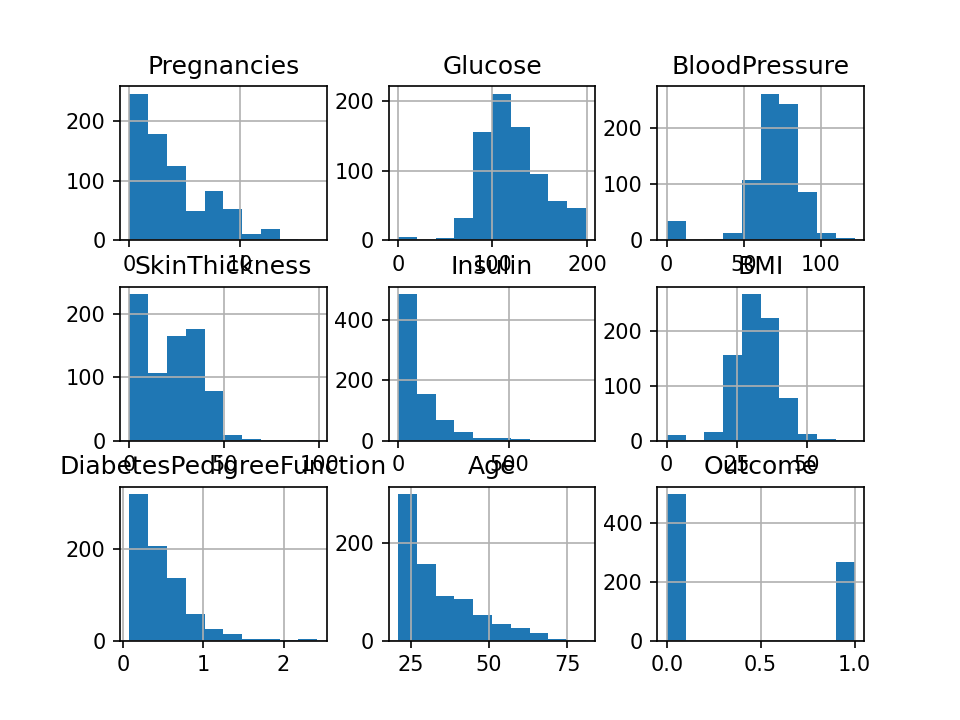

array([[<AxesSubplot:title={'center':'Pregnancies'}>, <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>, <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>, <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

In [15]:
data.hist()

<IPython.core.display.Javascript object>


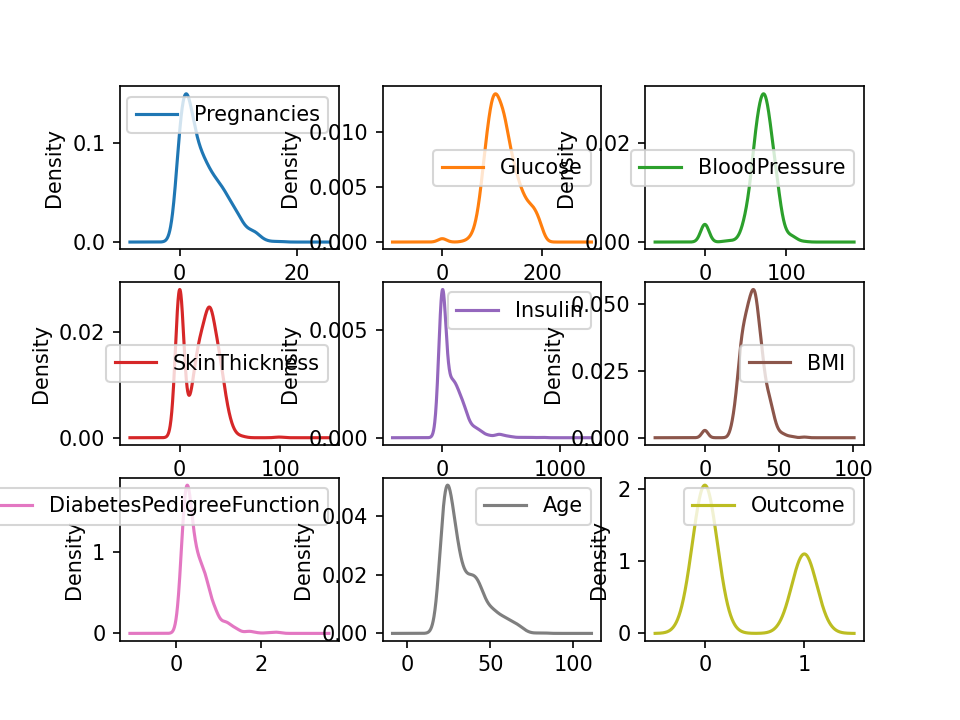

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
       [<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]], dtype=object)

In [16]:
data.plot(kind='density', subplots=True, layout=(3,3), sharex=False)

<IPython.core.display.Javascript object>


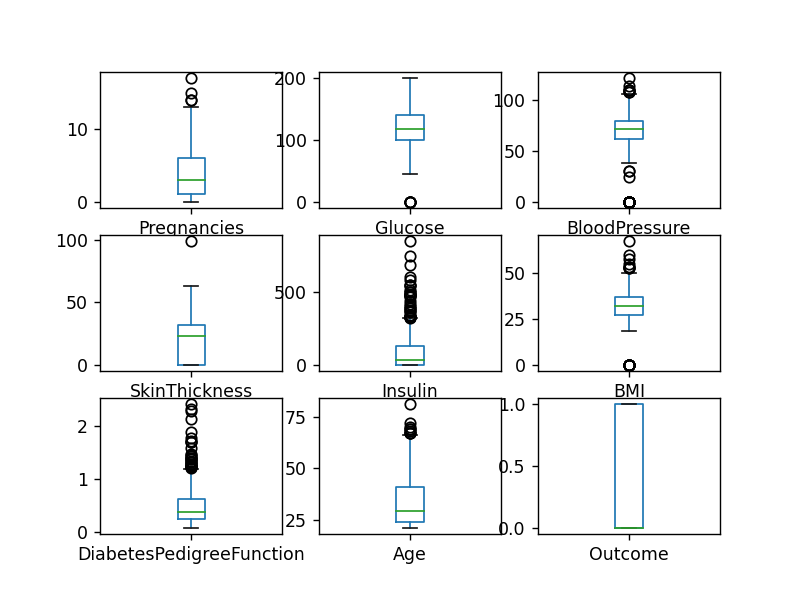

Pregnancies                    AxesSubplot(0.125,0.653529;0.227941x0.226471)
Glucose                     AxesSubplot(0.398529,0.653529;0.227941x0.226471)
BloodPressure               AxesSubplot(0.672059,0.653529;0.227941x0.226471)
SkinThickness                  AxesSubplot(0.125,0.381765;0.227941x0.226471)
Insulin                     AxesSubplot(0.398529,0.381765;0.227941x0.226471)
BMI                         AxesSubplot(0.672059,0.381765;0.227941x0.226471)
DiabetesPedigreeFunction           AxesSubplot(0.125,0.11;0.227941x0.226471)
Age                             AxesSubplot(0.398529,0.11;0.227941x0.226471)
Outcome                         AxesSubplot(0.672059,0.11;0.227941x0.226471)
dtype: object

In [12]:
data.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)

<IPython.core.display.Javascript object>


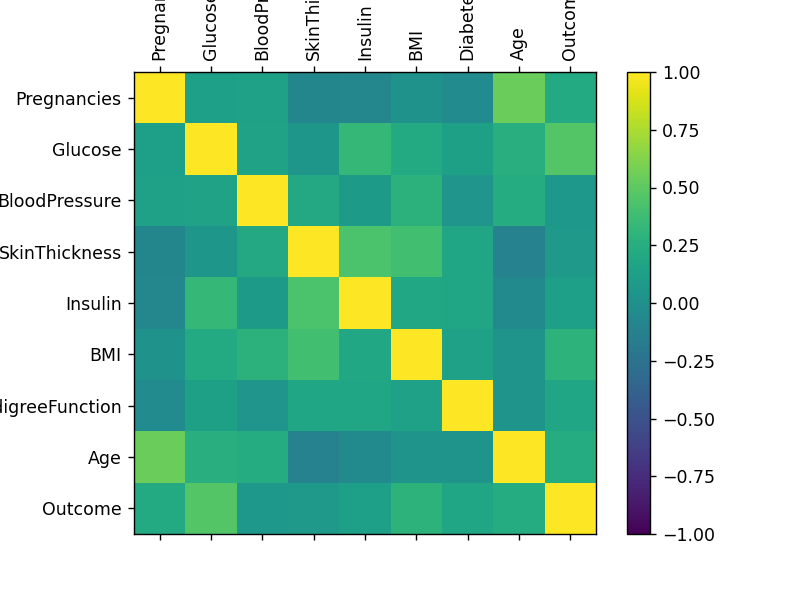

In [13]:
fig = mpl.pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(headings)
ax.set_yticklabels(headings)
mpl.pyplot.xticks(rotation=90)
mpl.pyplot.show()

<IPython.core.display.Javascript object>


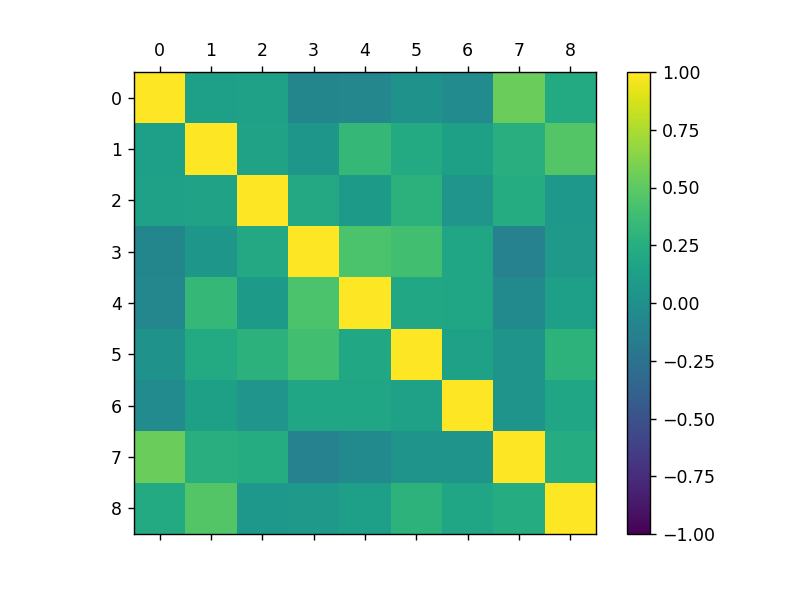

In [14]:
fig = mpl.pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data.corr(), vmin=-1, vmax=1)
fig.colorbar(cax)
mpl.pyplot.show()

<IPython.core.display.Javascript object>


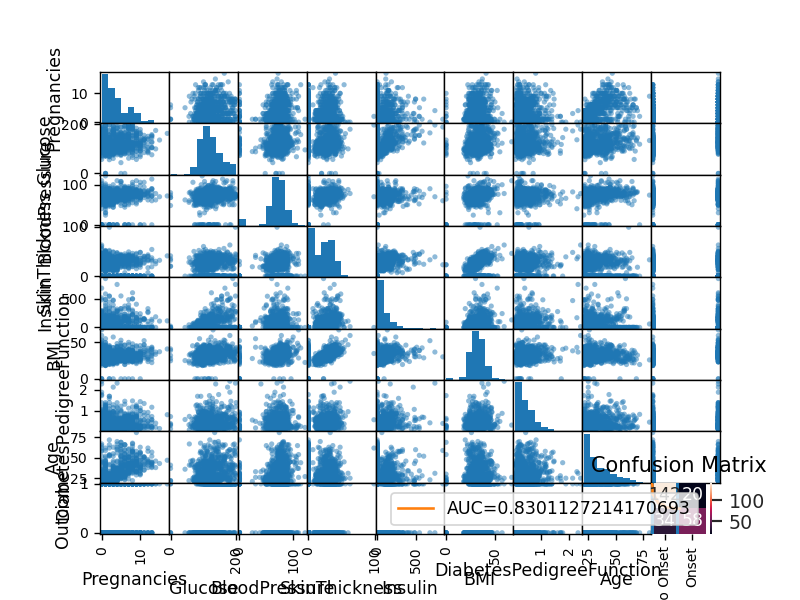

In [15]:
pd.plotting.scatter_matrix(data)
mpl.pyplot.show()

## Preprocessing

In [16]:
ar = df.values
ar.shape
x = ar[:,0:8]
y = ar[:,8]

In [17]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Rescaling Data

In [18]:
rescaler = sk.preprocessing.MinMaxScaler(feature_range=(0,1))
rescaledx = rescaler.fit_transform(x)
new_values = np.hstack([rescaledx,np.array([y]).T])
rescaled_df = pd.DataFrame(new_values, columns=headings)
rescaled_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1.0
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0.0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1.0
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0.0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1.0
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000,0.0
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000,0.0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000,0.0
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333,1.0


### Standardizing Data

In [19]:
sscaler = sk.preprocessing.StandardScaler().fit(x)
standardizedx = sscaler.transform(x)
new_values = np.hstack([standardizedx,np.array([y]).T])
standardized_df = pd.DataFrame(new_values, columns=headings)
standardized_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1.0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0.0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1.0
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0.0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1.0
...,...,...,...,...,...,...,...,...,...
763,1.827813,-0.622642,0.356432,1.722735,0.870031,0.115169,-0.908682,2.532136,0.0
764,-0.547919,0.034598,0.046245,0.405445,-0.692891,0.610154,-0.398282,-0.531023,0.0
765,0.342981,0.003301,0.149641,0.154533,0.279594,-0.735190,-0.685193,-0.275760,0.0
766,-0.844885,0.159787,-0.470732,-1.288212,-0.692891,-0.240205,-0.371101,1.170732,1.0


### Normalizing Data

In [20]:
nscaler = sk.preprocessing.Normalizer().fit(x)
normalizedx = nscaler.transform(x)
new_values = np.hstack([normalizedx,np.array([y]).T])
normalized_df = pd.DataFrame(new_values, columns=headings)
normalized_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.033552,0.827625,0.402628,0.195722,0.000000,0.187893,0.003506,0.279603,1.0
1,0.008424,0.716040,0.555984,0.244296,0.000000,0.224079,0.002957,0.261144,0.0
2,0.040398,0.924097,0.323181,0.000000,0.000000,0.117658,0.003393,0.161591,1.0
3,0.006612,0.588467,0.436392,0.152076,0.621527,0.185797,0.001104,0.138852,0.0
4,0.000000,0.596386,0.174127,0.152361,0.731335,0.187622,0.009960,0.143655,1.0
...,...,...,...,...,...,...,...,...,...
763,0.042321,0.427443,0.321640,0.203141,0.761779,0.139236,0.000724,0.266623,0.0
764,0.013304,0.811526,0.465629,0.179600,0.000000,0.244788,0.002262,0.179600,0.0
765,0.026915,0.651352,0.387582,0.123811,0.602905,0.141037,0.001319,0.161492,0.0
766,0.006653,0.838285,0.399184,0.000000,0.000000,0.200257,0.002322,0.312694,1.0


### Binarizing Data

In [21]:
binarizer = sk.preprocessing.Binarizer(threshold=0.0).fit(x)
binaryx = binarizer.transform(x)
new_values = np.hstack([binaryx, np.array([y]).T])
binarized_df = pd.DataFrame(new_values, columns=headings)
binarized_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
763,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
764,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
765,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
766,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


## Feature Selection

### Univariate Selection

Tests individual features to find features with strong correlation to output

In [22]:
test = skf.SelectKBest(score_func=skf.chi2, k=4)
fit = test.fit(x, y)
selected_features = np.hstack([fit.get_support(),[True]])
features = [label for i, label in enumerate(headings) if selected_features[i] ]
best4_univariate_df = df.filter(features)
best4_univariate_df

,Glucose,Insulin,BMI,Age,Outcome
0,148,0,33.6,50,1
1,85,0,26.6,31,0
2,183,0,23.3,32,1
3,89,94,28.1,21,0
4,137,168,43.1,33,1
...,...,...,...,...,...
763,101,180,32.9,63,0
764,122,0,36.8,27,0
765,121,112,26.2,30,0
766,126,0,30.1,47,1


### Recursive Feature Elimination

Identifies the combination of features that most accurately predict the output

In [23]:
model = sklm.LogisticRegression(max_iter=250)
rfe = skf.RFE(model, n_features_to_select=4)
fit = rfe.fit(x, y)
selected_features = np.hstack([fit.support_, [True]])
features = [label for i, label in enumerate(headings) if selected_features[i] ]
best4_recursive = df.filter(features)
best4_recursive

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Outcome
0,6,148,33.6,0.627,1
1,1,85,26.6,0.351,0
2,8,183,23.3,0.672,1
3,1,89,28.1,0.167,0
4,0,137,43.1,2.288,1
...,...,...,...,...,...
763,10,101,32.9,0.171,0
764,2,122,36.8,0.340,0
765,5,121,26.2,0.245,0
766,1,126,30.1,0.349,1


### Extra Trees Classifier

A bagged decision tree like Random Forest that can be used to estimate the importance of features

In [24]:
model=ske.ExtraTreesClassifier()
model.fit(x, y)
importance_df = pd.DataFrame([model.feature_importances_], columns = headings[0:-1])
importance_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.111917,0.233295,0.101825,0.07964,0.075365,0.142661,0.117597,0.137699


## Methods of splitting and evaluating data

### Splitting into Training and Test Sets

In [25]:
x_train, x_test, y_train, y_test = skm.train_test_split(x, y, test_size = .25, random_state=RANDOM_STATE)
model = sklm.LogisticRegression(max_iter=250)
model.fit(x_train, y_train)
result = model.score(x_test, y_test)
f"Accuracy: {result*100}%"

'Accuracy: 76.04166666666666%'

### K-fold Cross Validation

In [26]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.47395833333334%
Deviation:	4.107242264475913%


### Leave One Out Cross Validation

A variation of K-fold cross validation where the number of folds is the number of data items

In [27]:
oneOut = skm.LeaveOneOut()
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=oneOut)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.60416666666666%
Deviation:	41.68944689773287%


### Repeated Random Test-Train Splits

In [28]:
folds = 12
splits = skm.ShuffleSplit(n_splits=folds, random_state=RANDOM_STATE, test_size=.25)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	76.12847222222221%
Deviation:	2.4321051607850523%


## Evaluating Machine Learning Models

### Classification Accuracy

In [29]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits, scoring='accuracy')
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.47395833333334%
Deviation:	4.107242264475913%


### Logarithmic Loss

In [30]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_log_loss')
print(
f"""Logoss:\t\t{results.mean()}
Deviation:\t{results.std()}"""
)

Logoss:		-0.4839615279194916
Deviation:	0.06738849030314341


### Area Under ROC Curve

In [31]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits, scoring='roc_auc')
print(
f"""Logoss:\t\t{results.mean()}
Deviation:\t{results.std()}"""
)

Logoss:		0.8331282138147835
Deviation:	0.03879959510883493


In [32]:
x_train, x_test, y_train, y_test = skm.train_test_split(x, y, test_size = .33, random_state=seed)
model = sklm.LogisticRegression(max_iter=250)
model.fit(x_train, y_train)
y_prob = model.predict_proba(x_test)[:,1]
false_rate, true_rate, _ = skme.roc_curve(y_test, y_prob)
auc = skme.roc_auc_score(y_test, y_prob)


plt.plot(false_rate, true_rate, label=f"AUC={auc}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Confusion Matrix

In [33]:
x_train, x_test, y_train, y_test = skm.train_test_split(x, y, test_size = .33, random_state=seed)
model = sklm.LogisticRegression(max_iter=250)
model.fit(x_train, y_train)
prediction = model.predict(x_test)
matrix = skme.confusion_matrix(y_test, prediction)
print(matrix)

[[142  20]
 [ 34  58]]


In [34]:
df_cm = pd.DataFrame(matrix)
labels = ['No Onset', 'Onset']
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, fmt='g', xticklabels=labels, yticklabels=labels) # font size
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

### Classification Report

In [35]:
x_train, x_test, y_train, y_test = skm.train_test_split(x, y, test_size = .25, random_state=RANDOM_STATE)
model = sklm.LogisticRegression(max_iter=250)
model.fit(x_train, y_train)
prediction = model.predict(x_test)
report = skme.classification_report(y_test, prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       129
         1.0       0.69      0.49      0.57        63

    accuracy                           0.76       192
   macro avg       0.74      0.69      0.70       192
weighted avg       0.75      0.76      0.75       192



### Regression Metrics

#### Mean Absolute Error

Mean Absolute Error(MAE) is the sum of the differences between predicted and actual values. Shows the magnitude of the error but does not indicate positive or negative error

In [41]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LinearRegression()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_absolute_error')
print(
f"""Mean Absolute Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Absolute Error:	-0.33672400560575716
Deviation:		0.030170160888545


#### Mean Squared Error

Similar to MAE and can be rooted to find the Root Mean Squared Error

In [42]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LinearRegression()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.16271482498182563
Deviation:		0.024897057083022082


#### R Squared Metric

Measures how well predictions fit to the actual values, scales from 0 to 1 with 0 being no-fit and 1 being perfect fit

In [43]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LinearRegression()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='r2')
print(
f"""R Squared:\t{results.mean()}
Deviation:\t{results.std()}"""
)

R Squared:	0.27159503745668045
Deviation:	0.07440745726015974


## Checking the Accuracy of Machine Learning Algorithms

### Linear Classification Algorithms

#### Logistic Regression

In [44]:
x_train, x_test, y_train, y_test = skm.train_test_split(x, y, test_size = .25, random_state=RANDOM_STATE)
model = sklm.LogisticRegression(max_iter=250)
model.fit(x_train, y_train)
result = model.score(x_test, y_test)
f"Accuracy: {result*100}%"

'Accuracy: 76.04166666666666%'

In [45]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.47395833333334%
Deviation:	4.107242264475913%


#### Linear Discriminant Analysis

In [46]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = skda.LinearDiscriminantAnalysis()
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.34375%
Deviation:	4.15852068298732%


### Non-Linear Classification Algorithms

#### K-Nearest Neighbors

In [47]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = skn.KNeighborsClassifier()
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	72.265625%
Deviation:	5.454781267097243%


#### Naive Bayes

In [48]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sknb.GaussianNB()
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	76.04166666666666%
Deviation:	2.41500481653534%


#### Classification and Regression Trees

In [49]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = skt.DecisionTreeClassifier()
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	71.74479166666666%
Deviation:	5.160916974637087%


#### Support Vector Machines

In [50]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sksvm.SVC()
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	75.91145833333334%
Deviation:	6.066925915219658%


### Linear Regression Algorithms

#### Linear Regression

In [51]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LinearRegression()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.16271482498182563
Deviation:		0.024897057083022082


#### Ridge Regression

An extension of linear regression with a modified loss function that minimizes the complexity of the model based on the coefficient called the L2-Norm

In [52]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.Ridge()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.1627069624659303
Deviation:		0.024883571961838994


#### LASSO Regression

The Least Absolute Shrinkage and Selection Operator (LASSO) is an extension of linear regression with a modified loss function that minimizes the complexity of the model based on the coefficient called the L1-Norm

In [53]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.Lasso()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.17991173265535199
Deviation:		0.025692110686486802


#### ElasticNet Regression

A form of linear regression that uses both the L1-Norm and L2-Norm, combining the properties of ridge regression and LASSO regression

In [54]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.ElasticNet()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.17377869564792145
Deviation:		0.02540123477569358


### Non-Linear Regression Algorithms

#### K-Nearest Neighbors

In [55]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = skn.KNeighborsClassifier()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.27734375
Deviation:		0.054547812670972425


#### Classification and Regression Trees

Decision trees or Classification and Regresson Trees (CART) are used to find the best points to split the data and reduce the cost function, which is typicall mean squared error

In [56]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = skt.DecisionTreeRegressor()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.2890625
Deviation:		0.04059494080239556


#### Support Vector Machines

In [57]:
folds = 12
max_iter=250
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sksvm.SVR()
results = skm.cross_val_score(model, x, y, cv=splits, scoring='neg_mean_squared_error')
print(
f"""Mean Squared Error:\t{results.mean()}
Deviation:\t\t{results.std()}"""
)

Mean Squared Error:	-0.1732596977917034
Deviation:		0.03805275297543124


## Comparing Machine Learning Algorithms

### Comparing Classification Algorithms

LR: 	0.761,	0.0243 
LDA: 	0.763,	0.0241 
KNN: 	0.704,	0.0178 
CART: 	0.698,	0.0288 
NB: 	0.761,	0.0316 
SVM: 	0.75,	0.0217 


<IPython.core.display.Javascript object>


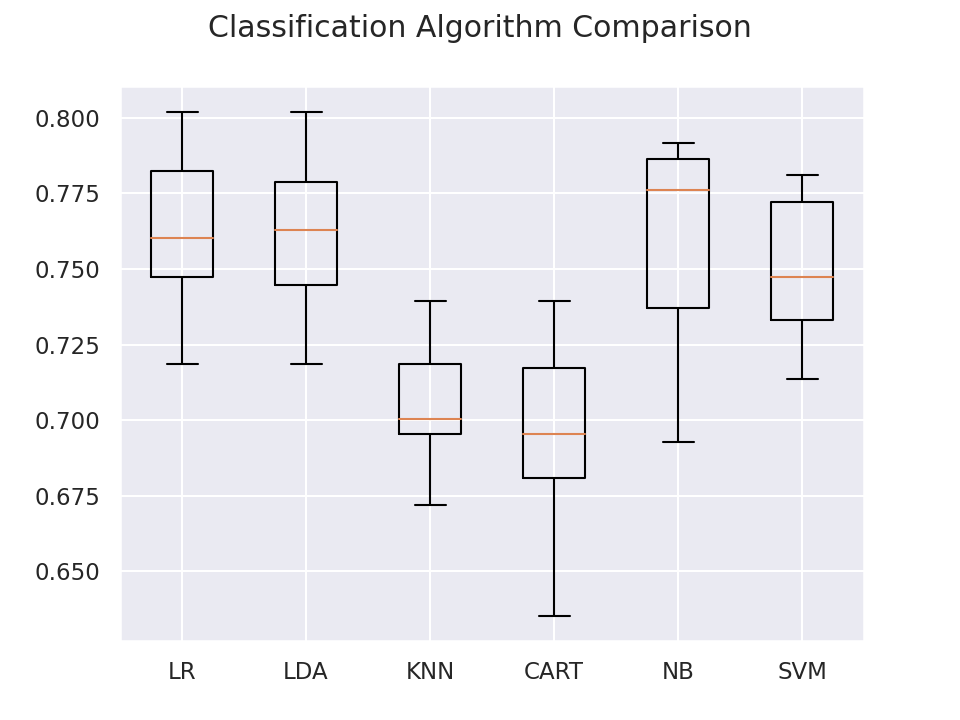

In [62]:
models = []
models.append(('LGR', sklm.LogisticRegression(max_iter=250)))
models.append(('LDA', skda.LinearDiscriminantAnalysis()))
models.append(('KNN', skn.KNeighborsClassifier()))
models.append(('CART', skt.DecisionTreeClassifier()))
models.append(('NB', sknb.GaussianNB()))
models.append(('SVM', sksvm.SVC()))

folds = 12
scoring='accuracy'
results = []
names = []
splits = skm.ShuffleSplit(n_splits=folds, random_state=RANDOM_STATE, test_size=.25)

for name, model in models:
    scores = skm.cross_val_score(model, x, y, cv=splits, scoring=scoring)
    results.append(scores)
    names.append(name)
    print(f"{name}: \t{scores.mean():.3},\t{scores.std():.3} ")

fig = plt.figure()
fig.suptitle('Classification Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LNR: 	-0.163,	0.0118 
RR: 	-0.163,	0.0118 
LASSO: 	-0.178,	0.00822 
EN: 	-0.171,	0.00748 
KNN: 	-0.296,	0.0178 
CART: 	-0.296,	0.0302 
SVM: 	-0.176,	0.0146 


<IPython.core.display.Javascript object>


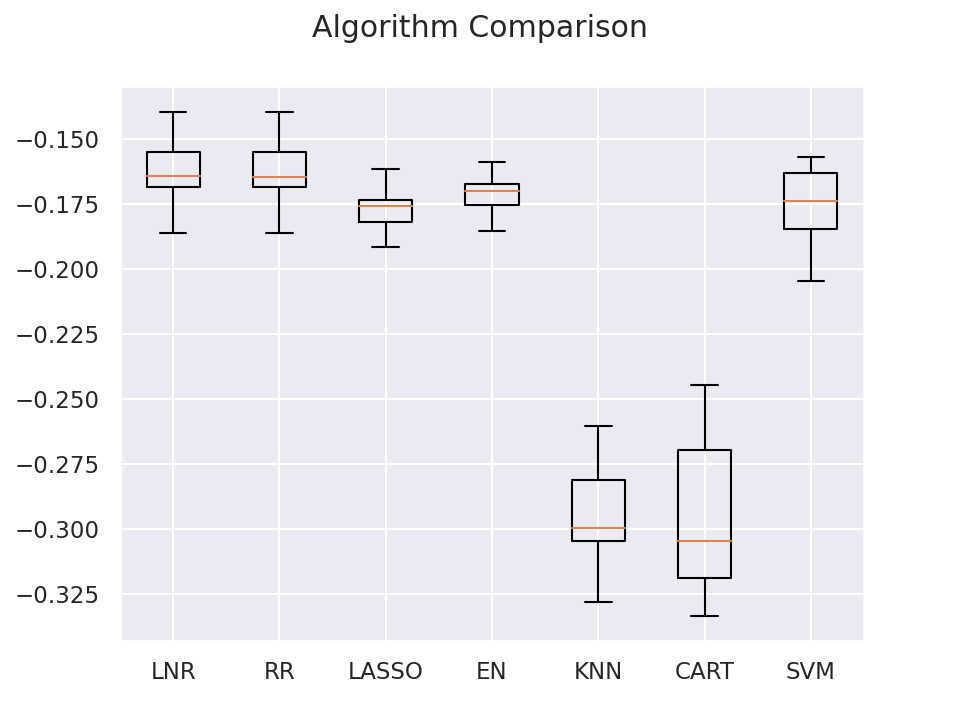

In [63]:
models = []
models.append(('LNR', sklm.LinearRegression()))
models.append(('RR', sklm.Ridge()))
models.append(('LASSO', sklm.Lasso()))
models.append(('EN', sklm.ElasticNet()))
models.append(('KNN', skn.KNeighborsClassifier()))
models.append(('CART', skt.DecisionTreeClassifier()))
models.append(('SVM', sksvm.SVR()))

folds = 12
results = []
names = []
scoring = 'neg_mean_squared_error'
splits = skm.ShuffleSplit(n_splits=folds, random_state=RANDOM_STATE, test_size=.25)

for name, model in models:
    scores = skm.cross_val_score(model, x, y, cv=splits, scoring=scoring)
    results.append(scores)
    names.append(name)
    print(f"{name}: \t{scores.mean():.3},\t{scores.std():.3} ")

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [69]:
folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)
model = sklm.LogisticRegression(max_iter=250)
results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.47395833333334%
Deviation:	4.107242264475913%


In [70]:
processes = []
processes.append(('standardize', skp.StandardScaler()))
processes.append(('LGR', sklm.LogisticRegression(max_iter=250)))
model = skpl.Pipeline(processes)

folds = 12
splits = skm.KFold(n_splits=folds, random_state=RANDOM_STATE, shuffle=True)

results = skm.cross_val_score(model, x, y, cv=splits)
print(
f"""Accuracy:\t{results.mean()*100}%
Deviation:\t{results.std()*100}%"""
)

Accuracy:	77.21354166666666%
Deviation:	4.1072422644759135%


In [96]:
new_df = df[df['Outcome'] == 1]
vals = new_df.values
x = vals[:,0:8]
y = vals[:,8]
x_train, x_test, y_train, y_test = skm.train_test_split(x, y, test_size = .25, random_state=RANDOM_STATE)
sigma_f, l = 1.5, 2
X = x_train[:10,6:7]
kernel = GPy.kern.RBF(1, sigma_f, l)
sn.heatmap(kernel.K(X, X))
plt.show()

In [86]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [87]:
x_train[10:20,4:5]

array([[  0.],
       [225.],
       [130.],
       [325.],
       [  0.],
       [  0.],
       [  0.],
       [230.],
       [  0.],
       [ 88.]])

<IPython.core.display.Javascript object>


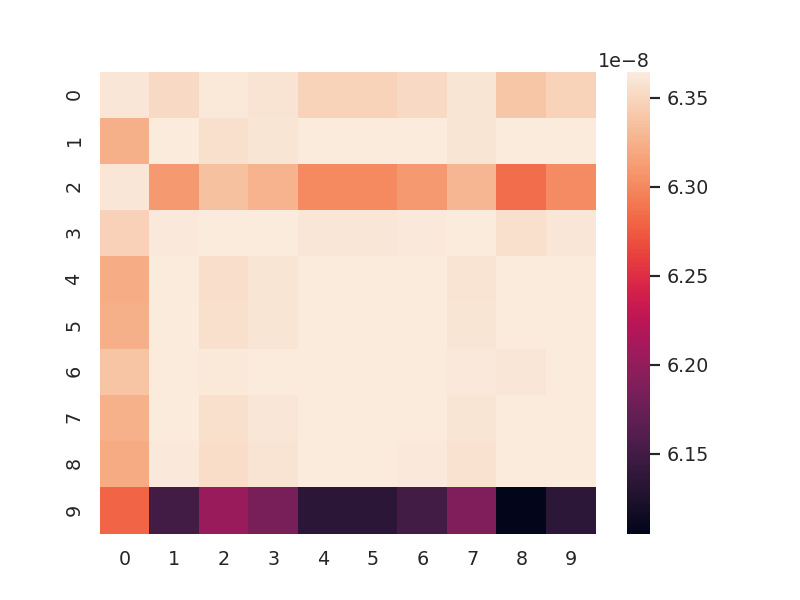

In [109]:
sn.heatmap(kernel.K(X, x_train[10:20,6:7]))
plt.show()

In [88]:
model = GPy.models.GPRegression(X,,kernel) 
mean, variance = model.predict(np.array([[1]]))
print(mean, variance)

AssertionError: 

In [71]:
y_train[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [97]:
def generate_noisy_points(n=10, noise_variance=1e-6):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y
_, y = generate_noisy_points(noise_variance=0.003)
model = GPy.models.GPRegression(X,y,kernel) 
mean, variance = model.predict(np.array([[1]]))
print(mean, variance)

[[0.006888]] [[1.138172]]


In [98]:
iris = skds.load_iris()

NameError: name 'skds' is not defined

In [99]:
x = iris.data
y = iris.target

NameError: name 'iris' is not defined


Name : GP regression
Objective : 11.931533825407922
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |  6.36446260888483e-08  |      +ve      |        
  rbf.lengthscale          |     7.896228762636327  |      +ve      |        
  Gaussian_noise.variance  |    0.6366287436257334  |      +ve      |        


<IPython.core.display.Javascript object>


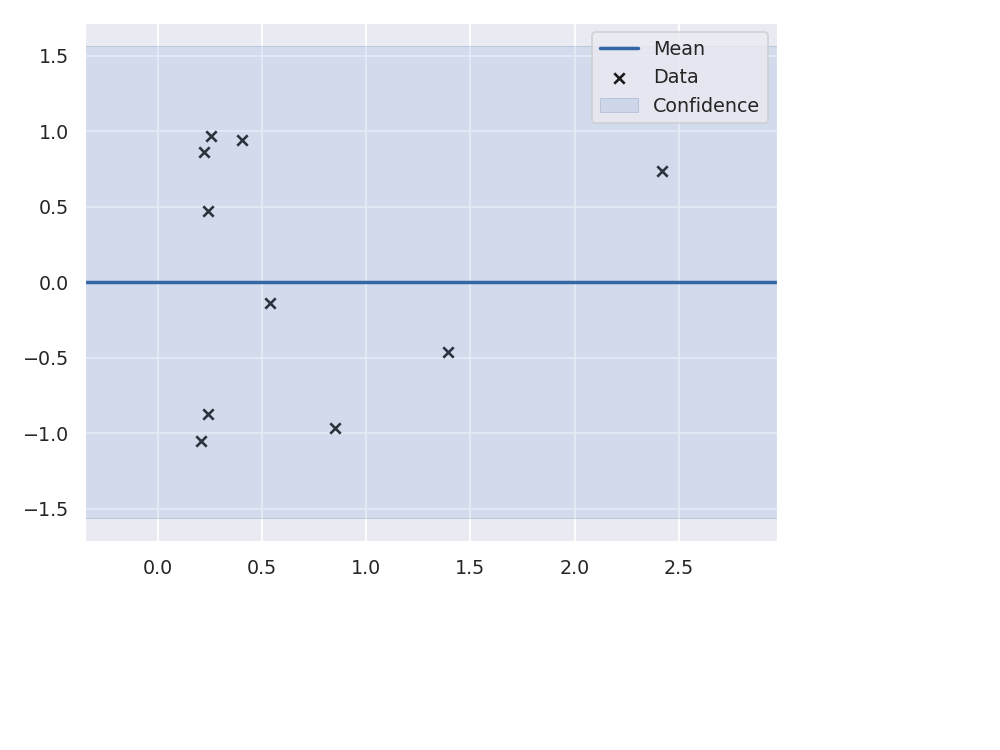

In [107]:
print(model)
model.plot()
plt.show()

In [101]:
model.optimize()

In [102]:
print(model)


Name : GP regression
Objective : 11.931533825407922
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |  6.36446260888483e-08  |      +ve      |        
  rbf.lengthscale          |     7.896228762636327  |      +ve      |        
  Gaussian_noise.variance  |    0.6366287436257334  |      +ve      |        


<IPython.core.display.Javascript object>


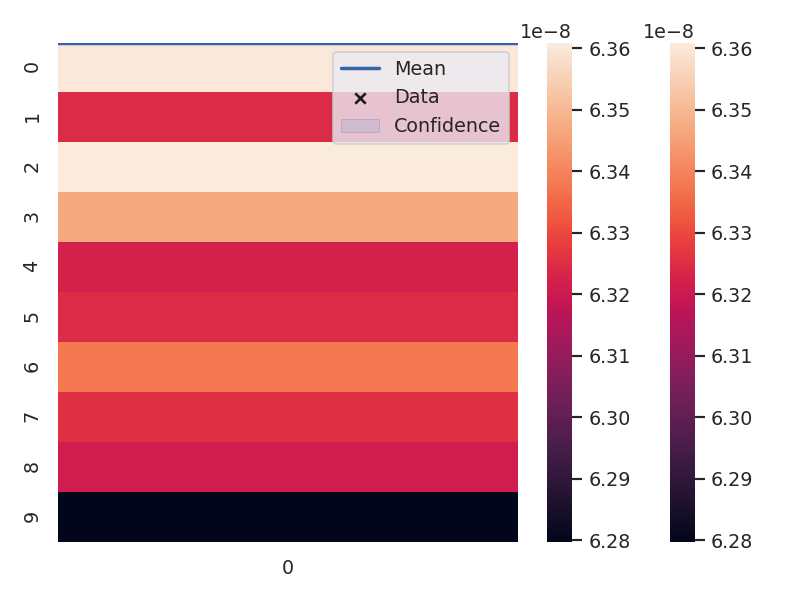

In [103]:
model.plot()
plt.show()